In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

from src.water import Water

# Test runs

In [2]:
flat = np.zeros((5, 5))
water = flat[:,:]
water[0, 0] = 1

foo = Water(flat, water)

steps = 15
record = np.zeros([steps, water.size])

gravity = []
rainfall = []

for i in tqdm(range(steps)):
    record[i, :] = foo.water_level.reshape(-1)
    gravity.append(foo.gravity())
    rainfall.append(foo.rainfall())
    foo.step()

100%|██████████| 15/15 [00:03<00:00,  4.76it/s]


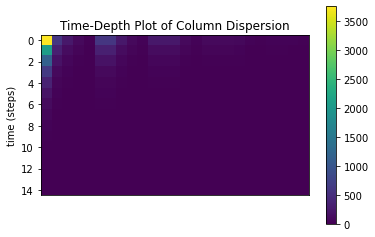

In [3]:
plt.imshow(np.flip(record, axis=0))
plt.colorbar()
plt.title("Time-Depth Plot of Column Dispersion")
plt.ylabel("time (steps)")
plt.xticks([])
plt.savefig("imgs/time_depth_column.png")


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]

[1.79999995 0.06666667 0.         0.         0.         0.06666667
 0.06666667 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]

[3.23999977e+00 2.40000010e-01 9.33333393e-03 0.00000000e+00
 0.00000000e+00 2.40000010e-01 2.40000010e-01 9.33333393e-03
 0.00000000e+00 0.00000000e+00 9.33333393e-03 9.33333393e-03
 2.66666687e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]

[5.83199978e+00 6.48000002e-01 4.90666702e-02 1.55555573e-03
 0.00000000e+00 6.48000002e-01 6.48000002e-01 4.90666702e-02
 1.66222244e-03 0.00000000e+00 4.90666702e-02 4.90666702e-02
 1.97333340e-02 7.28888961e-04 0.00000000e+00 1.55555573e-03
 1.66222244e-03 7.28888961e-04 1.0

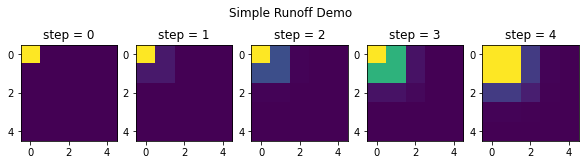

In [4]:
fig, axes = plt.subplots(1, 5, figsize=((10, 2.5)))
axes = iter(axes)

for i in range(5):
    ax = next(axes)
    ax.set_title(f"step = {i}")

    print()
    print(record[i, :])
    ax.imshow(record[i, :].reshape([5, 5]), vmin=0, vmax=1)

fig.suptitle("Simple Runoff Demo")
fig.savefig("imgs/one_drop_spread.png")
plt.show()

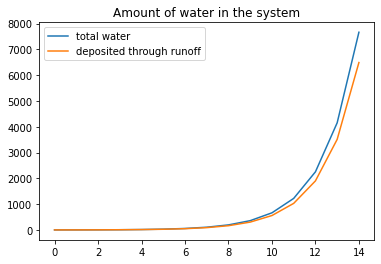

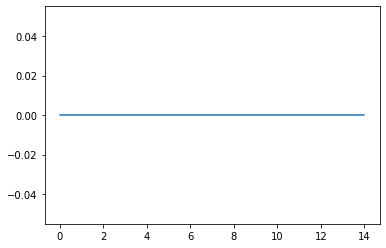

In [5]:
plt.plot(np.sum(record, axis=1), label="total water")
plt.title("Amount of water in the system")
plt.plot(np.sum(gravity, axis=(1, 2)), label="deposited through runoff")
plt.legend()
plt.show()

plt.plot(np.sum(rainfall, axis=(1, 2)))

Okay so conservation of mass is broken ahhhhhhhh!

# Why is conservation of mass broken

In [7]:
# hypothesis thinks we're brokwn for this input, but I can't reproduce it here :((

bowl = np.zeros((5, 5))
bowl[0, :] = 1e6
bowl[-1, :] = 1e6
bowl[:, 0] = 1e6
bowl[:, -1] = 1e6

foo = Water(bowl, np.zeros((5, 5)))
for _ in range(100):
    foo.step()
    # print(foo.rainfall())
    # # print(foo.inundation())
    # print(foo.gravity())
    
    # print(foo.water_level)
    assert (foo.water_level == 0).all()

print(bowl)

print(foo.gravity())

[[1000000. 1000000. 1000000. 1000000. 1000000.]
 [1000000.       0.       0.       0. 1000000.]
 [1000000.       0.       0.       0. 1000000.]
 [1000000.       0.       0.       0. 1000000.]
 [1000000. 1000000. 1000000. 1000000. 1000000.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


# Big boy runs

In [8]:
path = 'beauford.npz'
with np.load(path) as data:
    dem = data['beauford']

# downsample and remove negative values
dem = dem[::7, ::10][:, :234]
dem = np.where(dem < 0, 0, dem)
dem.shape

(234, 234)

In [9]:
houses_x = np.array([117, 119, 120, 115, 130])
houses_y = np.array([100, 115, 123, 119, 139])

/var/folders/l_/zjyw1l0d37x3lbbq6x4vvs_00000gn/T/ipykernel_1066/1896412566.py:2: RuntimeWarning: divide by zero encountered in log
  plt.contour(np.log(dem), levels=100, zorder=0)


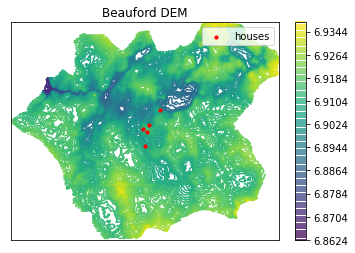

In [10]:
plt.scatter(houses_x, houses_y, c='r', s=10, label="houses", zorder=1)
plt.contour(np.log(dem), levels=100, zorder=0)
plt.legend()
plt.colorbar()
plt.title("Beauford DEM")
plt.xticks([])
plt.yticks([])
plt.savefig("imgs/beauford_dem.png")

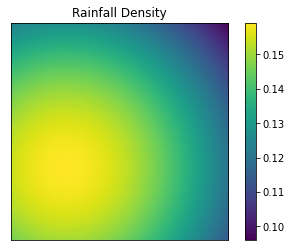

In [11]:
x = np.linspace(0, 1, dem.shape[1])
y = np.linspace(0, 1, dem.shape[0])
xm, ym = np.meshgrid(x, y)
pos = np.dstack((xm, ym))
rv = stats.multivariate_normal([0.25, 0.33], np.eye(2))
rain = rv.pdf(pos)

plt.imshow(np.flip(rain, axis=0))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title("Rainfall Density")
plt.savefig("imgs/rainfall_density.png")

In [13]:
def heights_at_houses(water: Water, houses_x, houses_y):
    heights = []
    for x, y in zip(houses_x, houses_y):
        heights.append(water.water_level[int(x), int(y)])
    return np.array(heights)

def run(dem, rain, houses_x, houses_y, n_steps):
    water = Water(ground_level=dem, chance_rain=rain)
    house_levels = np.zeros([n_steps, len(houses_x)])
    for step in tqdm(range(n_steps)):
        water.step()
        house_levels[step] = heights_at_houses(water, houses_x, houses_y)
    return house_levels

house_levels = run(dem, rain, houses_x, houses_y, n_steps=100)

100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


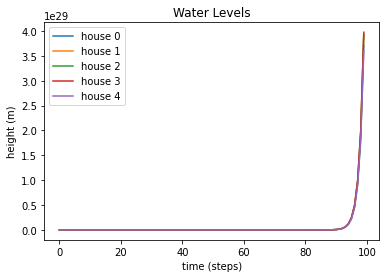

In [14]:
for i in range(house_levels.shape[1]):
    plt.plot(house_levels[:, i], label=f"house {i}")
plt.legend()
plt.title("Water Levels")
plt.ylabel("height (m)")
plt.xlabel("time (steps)")
plt.savefig("imgs/water_levels_houses_demo.png")

what is going on ???